In [1]:
import torch
import math
from matplotlib import pyplot as plt

# BPR

## Adaptive BPR formulation
Assume an inderlying recommender, parameterized by $\Theta$, that models, for each user $u \in U$, the relevance of all the items $i \in I$. Denote $x_{ui}$ the relevance score of item $i$ to user $u$. Then, $x_{uij}(\Theta) = x_{ui}(\Theta) - x_{uj}(\Theta)$ models how much user $u$ prefers item $i$ over $j$. Given a user $u$ and a pair of items $(i, j)$, the probability that the user $u$ will prefer item $i$ over $j$ can be modeled as

$$
    P(i >_u j | \Theta) = \sigma(x_{uij}(\Theta)),
$$

For notation facility, the conditionality on $\Theta$ can be ommited. Now let $\rho_{ui}$ denote the uncertainty around $x_{ui}$ and assume $\rho_{uij} = \rho_{ui} + \rho_{uj}$ is the uncertainty around $x_{uij}$. Then, the same probability can me modeled as

$$
    P(i >_u j | \Theta) = \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right)
$$

Consider $u^+$ the set of items which user $u$ provided positive feedback about. Then, in both cases, the optimal $\Theta$ can be choosen as

$$
    \arg_\theta \min \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+}P(j >_u i | \Theta) = \arg_\theta \min \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} 1 - \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right)
$$

<span style="color:red">
    Note: This is not exactly equal to the original BPR formulation. There, a prior distribution for $\Theta$ is defined and then the optimal $\Theta$ is choosen via maximum likelihood estimation.
</span>

## New idea
The relevance scores $x_{ui}$ can be treated as random variables and assumed to be normally distributed, that is, $x_{ui}|\Theta \sim N(\mu_{ui}, \sigma^2_{ui})$. Therefore, $x_{uij} = x_{ui} - x_{uj}$ is a also normally distributed, whith mean $\mu_{ui} - \mu_{uj}$ and variance $\sigma^2_{ui} + \sigma^2_{uj}$. In this setup, the probability that the user $u$ will prefer item $i$ over $j$ can be written as

$$
    P(i >_u j | \Theta) = P(x_{uij} > 0 | \Theta) = 1 - P(x_{uij} \leq 0 | \Theta)
$$

As $x_{uij}$ is normally distributed, we can explicitly calculate this probability

$$
    P(i >_u j | \Theta) = 1 - P\left(\frac{x_{uij} - (\mu_{ui} - \mu_{uj})}{\sqrt{\sigma^2_{ui} + \sigma^2_{uj}}} \leq \frac{- (\mu_{ui} - \mu_{uj})}{\sqrt{\sigma^2_{ui} + \sigma^2_{uj}}} \Bigg| \Theta \right) = 1 - \Phi \left( \frac{-(\mu_{ui} - \mu_{uj})}{\sqrt{\sigma^2_{ui} + \sigma^2_{uj}}}\right)
$$

Where $\Phi$ is the standard gaussian distribution cumulative distribution function. Therefore, the optimal $\Theta$ can be choosen as

$$
    \arg_\theta \min \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+}P(j >_u i | \Theta) = \arg_\theta \min \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+}\Phi \left( \frac{\mu_{uj} - \mu_{ui}}{\sqrt{\sigma^2_{ui} + \sigma^2_{uj}}}\right)
$$

# The loss as a function of the difference $x_{uij}$ for different values of $\rho$

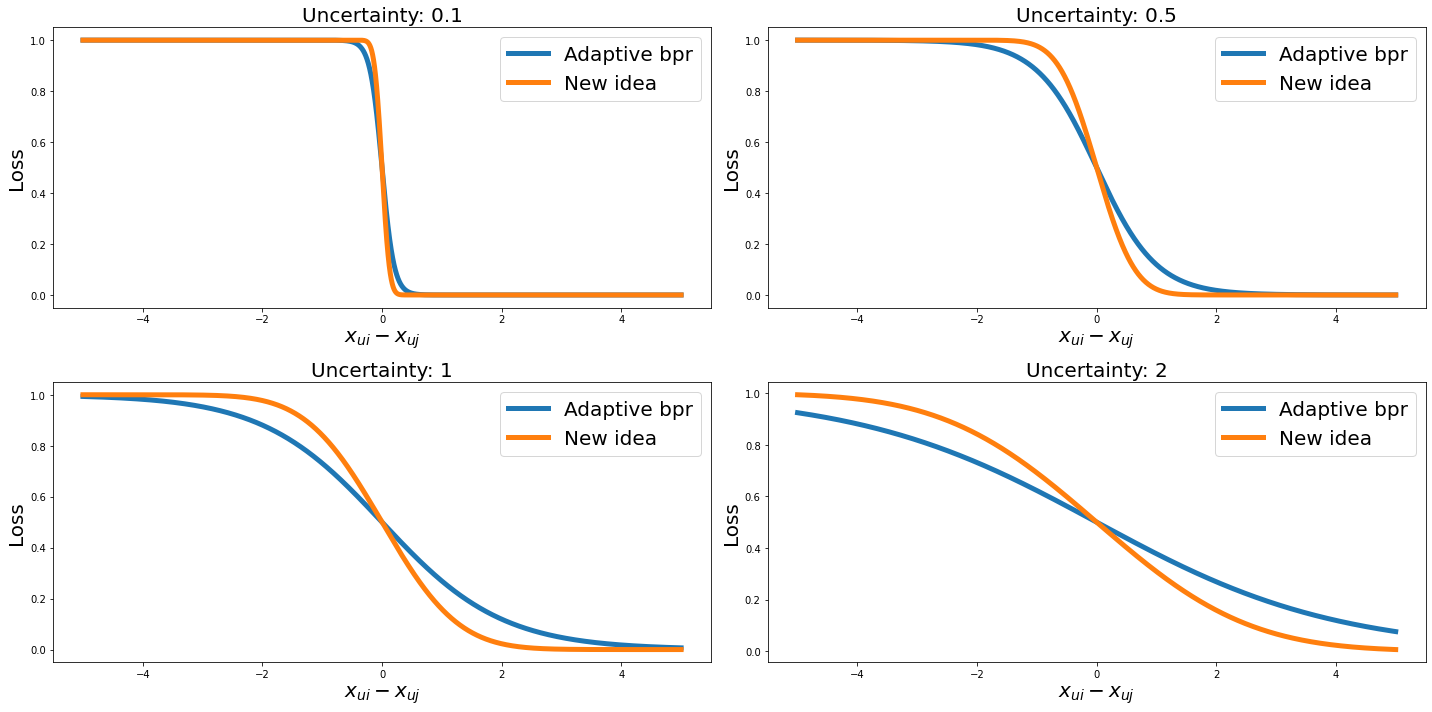

In [2]:
def adaptive_bpr(diff, unc):
    return 1 - torch.sigmoid(diff / unc)

def uncertain(diff, unc):
    return 0.5 * (1 + torch.erf((-diff / unc / math.sqrt(2))))

x = torch.linspace(-5, 5, 10000)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for uncertainty, grid in zip([0.1, 0.5, 1, 2], [(0, 0), (0, 1), (1, 0), (1, 1)]):
    ax[grid].plot(x, adaptive_bpr(x, uncertainty), label='Adaptive bpr', linewidth=5)
    ax[grid].plot(x, uncertain(x, uncertainty), label='New idea', linewidth=5)
    ax[grid].set_title('Uncertainty: {}'.format(uncertainty), fontsize=20)
    ax[grid].set_xlabel(r'$x_{ui} - x_{uj}$', fontsize=20)
    ax[grid].set_ylabel('Loss', fontsize=20)
    ax[grid].legend(fontsize=20)
f.tight_layout()

When $\rho$ = 1, the adaptive BPR reduces to the vanilla BPR. For every $\rho$, the new idea's criterion is basically a less smooth version of the adaptive BPR. Nevertheless, it holds the advantage of the probabilistic formulation, and its uncertainty values have a clear motivation, that is, the variances of the gaussian distributions estimated.

## Why not to replicate the BPR formulation?

On BPR, maximum likelihood estimation is used. The posterior distribution of the underlying recommender parameters for some user $u$ is

$$
    P(\Theta | >_u) \propto P(>_u | \Theta) P(\Theta)
$$

Assume that the preferences of each user are independent, and that the preference relation over each pair of items for each user are also independent. Then the likelihood of all the users preferences for the training data is

$$
    \prod_{u \in U} P(>_u | \Theta) = \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} P(i >_u j | \Theta) = \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} \sigma(x_{uij})
$$

Moreover, A priori, it is assumed that $\Theta \sim N(0, \lambda I)$, where $\lambda$ controls the model complexity. Finally, the likelihood of the log-posteriori is maximized,

$$
    \log P(\Theta | >_u) = \log P(>_u | \Theta) P(\Theta) = \log \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} \sigma(x_{uij}) P(\Theta) = \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) + \log P(\Theta) = \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) - \lambda ||\Theta||^2
$$

The same development above can be replicated for the adaptive BPR case, that is, for

$$
    P(i >_u j | \Theta) = \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right)
$$

In this case, the log-likelihood a posteriori is 

$$
    \log P(\Theta | >_u) = \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) - \lambda ||\Theta||^2
$$

The problem is that, if the term $\frac{x_{uij}}{\rho_{uij}} \rightarrow -\infty$, then $\sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) \rightarrow 0$, and therefore, $\log \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) \rightarrow -\infty$. The same effect also happens with the gaussian CDF $\Phi$. This becomes a problem when certain uncertainty ($\rho$) values are too small, because $\frac{x_{uij}}{\rho_{uij}}$ decreases much faster as $x_{uij}$ decreases. In practice, if $x_{uij} = -10$ and $\rho_{uij} = 0.1$, $\frac{x_{uij}}{\rho_{uij}} = -100$ and PyTorch's sigmoid function already approximates $\sigma\left(\frac{x_{uij}}{\rho_{uij}}\right)$ to 0 and therefore $\log \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) = -\infty$.

In [3]:
x = -10; rho = 0.1
torch.tensor(x / rho).sigmoid(); torch.tensor(x / rho).sigmoid().log()

tensor(-inf)